<a href="https://colab.research.google.com/github/Mohawkins/Gas-Refinery-CS-668-Capstone-Project/blob/main/U_S_Natural_Gas_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Done. Outputs written to: /content/output


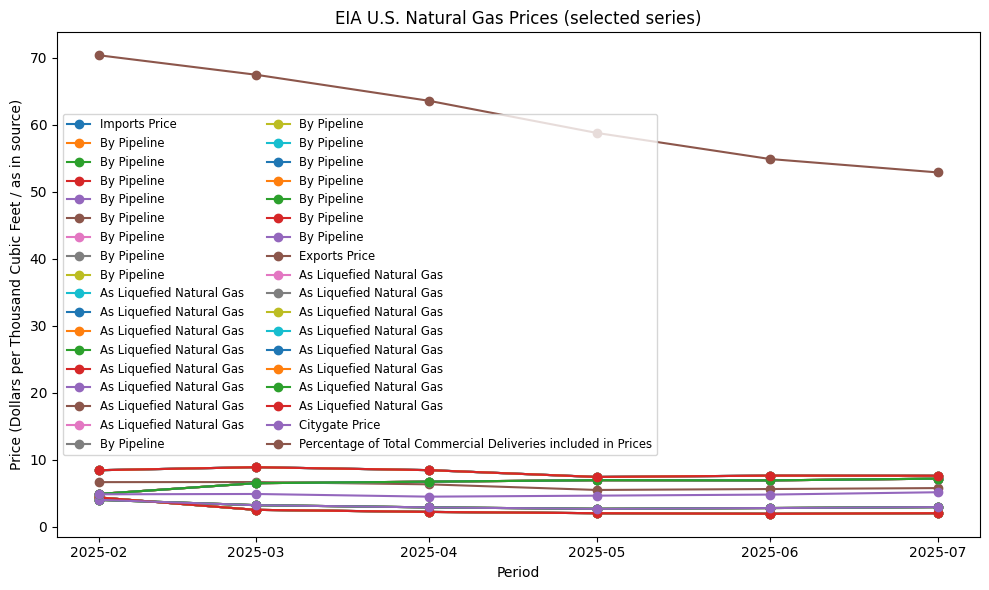

In [ ]:
import sys
import re
import argparse
import logging
from pathlib import Path

import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# ---- Configuration ----
DEFAULT_FILE = Path("./U.S. Natural Gas Prices.htm")
OUT_DIR = Path("./output")
PLOT_DIR = OUT_DIR / "plots"
LOG_LEVEL = logging.INFO

# ---- Helpers ----
def text_or_none(td):
    if td is None:
        return None
    txt = td.get_text(strip=True)
    return txt if txt != "" else None

def parse_price_cell(txt):
    """
    Convert the cell text to float or NaN.
    Recognizes: "NA", "-", "--", "W" as missing.
    Strips commas and parentheses if present.
    """
    if txt is None:
        return pd.NA
    txt = txt.strip()
    if txt in ("", "-", "--", "NA", "W", "NA "):
        return pd.NA
    # Remove commas, parentheses, and non-numeric extras
    txt_clean = txt.replace(",", "")
    # Sometimes there may be footnote markers; remove non-numeric except . and -
    txt_clean = re.sub(r"[^\d\.\-eE]", "", txt_clean)
    try:
        return float(txt_clean)
    except Exception:
        return pd.NA

# ---- Main parsing function ----
def parse_eia_html(path: Path):
    html = path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, "lxml")

    # Find the main data table. Based on the uploaded file, it's <table class="data1">
    table = soup.find("table", class_="data1")
    if table is None:
        raise ValueError("Could not find table with class 'data1' in HTML.")

    # Extract header months from <th class="Series5"> etc.
    header_row = table.find("tr")
    # We'll find all THs under the top rows that look like month headers (class starts with 'Series')
    month_ths = table.find_all("th", class_=re.compile(r"Series|Cross"))
    # But the table includes many THs earlier. We'll attempt to extract the row that contains 'Feb-25', 'Mar-25', ...
    months = []
    # strategy: find all th text strings that match a pattern like 'Jan-25' or 'Jan-2025' or months with dash.
    for th in table.find_all("th"):
        t = th.get_text(strip=True)
        if re.match(r"^[A-Za-z]{3,}\-\d{2,4}$", t):  # e.g., Feb-25 or Feb-2025
            months.append(t)
    # Fall back: some pages use abbreviations or different structure; if months empty, try header cells in the 2nd row
    if not months:
        # try the first tr after the 'Show Data By' block that has many ths
        rows = table.find_all("tr")
        for r in rows[:10]:
            cells = [c.get_text(strip=True) for c in r.find_all(["th","td"])]
            cand = [c for c in cells if re.match(r"^[A-Za-z]{3,}\-\d{2,4}$", c)]
            if cand:
                months = cand
                break

    if not months:
        logging.warning("Could not detect month columns heuristically. Will try to parse by column positions.")
    else:
        logging.info(f"Detected month columns: {months}")

    # Now iterate rows that have class "DataRow"
    data_rows = table.find_all("tr", class_=re.compile(r"DataRow"))
    if not data_rows:
        # fallback: find rows containing <td class="DataStub">
        data_rows = []
        for tr in table.find_all("tr"):
            if tr.find("td", class_=re.compile(r"DataStub")):
                data_rows.append(tr)
    if not data_rows:
        raise ValueError("No data rows found in the table.")

    # We'll build a list of dicts
    records = []
    for tr in data_rows:
        # Series name is in a <td class="DataStub"> that contains a nested <td class="DataStub1">
        series_td = tr.find("td", class_=re.compile(r"DataStub"))
        series_name = None
        if series_td:
            inner = series_td.find(class_=re.compile(r"DataStub1"))
            if inner:
                series_name = inner.get_text(strip=True)
            else:
                # fallback: text of series_td
                series_name = series_td.get_text(" ", strip=True)
        # Data cells are subsequent <td> elements with numbers / NA
        data_tds = tr.find_all("td")
        # data_tds often start with the stub cell; find numeric-looking cells after the stub
        values = []
        for td in data_tds:
            cls = td.get("class") or []
            # skip the stub cell(s)
            if any(re.search(r"DataStub", c) for c in cls):
                continue
            # accept cells that look like DataB, Current2, DataHist etc.
            if any(re.search(r"DataB|Current|DataHist|Cross|Series", c) for c in cls):
                values.append(text_or_none(td))
            else:
                # also accept plain td that look numeric
                txt = td.get_text(strip=True)
                # treat blank or link to history as not numeric
                if re.search(r"^\(?[\d,.\-]+\)?$", txt) or txt in ("NA", "-", "--", "W"):
                    values.append(txt)
        # If we didn't capture by class, try capturing all td after the first
        if not values:
            tds = tr.find_all("td")
            if len(tds) >= 2:
                values = [td.get_text(strip=True) for td in tds[1:]]
        # Convert values to floats where possible
        numeric_values = [parse_price_cell(v) for v in values]
        # Build record
        record = {"series": series_name}
        # assign months to values if months found, else use positional columns: col_1, col_2...
        if months:
            for m, v in zip(months, numeric_values):
                record[m] = v
        else:
            for i, v in enumerate(numeric_values, start=1):
                record[f"col_{i}"] = v
        records.append(record)

    # Build DataFrame
    df = pd.DataFrame(records)
    # Move series to index
    df = df.set_index("series")
    return df

# ---- CLI / Execution ----
# Modified to run directly in the notebook without argparse
def main():
    logging.basicConfig(level=LOG_LEVEL, format="%(levelname)s: %(message)s")

    html_path = DEFAULT_FILE # Use the default file path directly

    if not html_path.exists():
        logging.error("File not found: %s", html_path)
        # sys.exit(2) # Don't exit in notebook

    OUT_DIR.mkdir(parents=True, exist_ok=True)
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    logging.info("Parsing %s ...", html_path)
    df = parse_eia_html(html_path)
    if df.empty:
        logging.error("Parsed DataFrame is empty.")
        # sys.exit(3) # Don't exit in notebook

    # Save wide CSV
    wide_csv = OUT_DIR / "eia_natural_gas_prices_wide.csv"
    df.to_csv(wide_csv)
    logging.info("Saved wide CSV: %s", wide_csv)

    # Save long (tidy) CSV
    df_reset = df.reset_index().melt(id_vars=["series"], var_name="period", value_name="value")
    long_csv = OUT_DIR / "eia_natural_gas_prices_long.csv"
    df_reset.to_csv(long_csv, index=False)
    logging.info("Saved long CSV: %s", long_csv)

    # Simple plot: top N series with most non-null values
    # choose top series by non-null count (and then by mean value)
    # Use a default value for top if not provided (since we removed argparse)
    top_n = 8
    non_null_counts = df.notna().sum(axis=1)
    top_series = non_null_counts.sort_values(ascending=False).head(top_n).index.tolist()
    logging.info("Top series for plotting: %s", top_series)

    # Convert all columns to numeric (already attempted), then transpose for plotting
    df_plot = df.loc[top_series].transpose()
    # df_plot index are periods; try to convert period strings like 'Feb-25' to pandas Period or datetime
    try:
        # Try parse formats like 'Feb-25' -> %b-%y
        df_plot.index = pd.to_datetime(df_plot.index, format="%b-%y", errors="coerce")
        if df_plot.index.isnull().all():
            # fallback: try %b-%Y
            df_plot.index = pd.to_datetime(df_plot.index, format="%b-%Y", errors="coerce")
    except Exception:
        pass

    plt.figure(figsize=(10, 6))
    for col in df_plot.columns:
        plt.plot(df_plot.index, df_plot[col], marker="o", label=col)
    plt.xlabel("Period")
    plt.ylabel("Price (Dollars per Thousand Cubic Feet / as in source)")
    plt.title("EIA U.S. Natural Gas Prices (selected series)")
    plt.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plot_file = PLOT_DIR / "eia_ng_prices_top_series.png"
    plt.savefig(plot_file)
    logging.info("Saved plot: %s", plot_file)
    print(f"Done. Outputs written to: {OUT_DIR.resolve()}")

if __name__ == "__main__":
    main()